In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

In [2]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [3]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

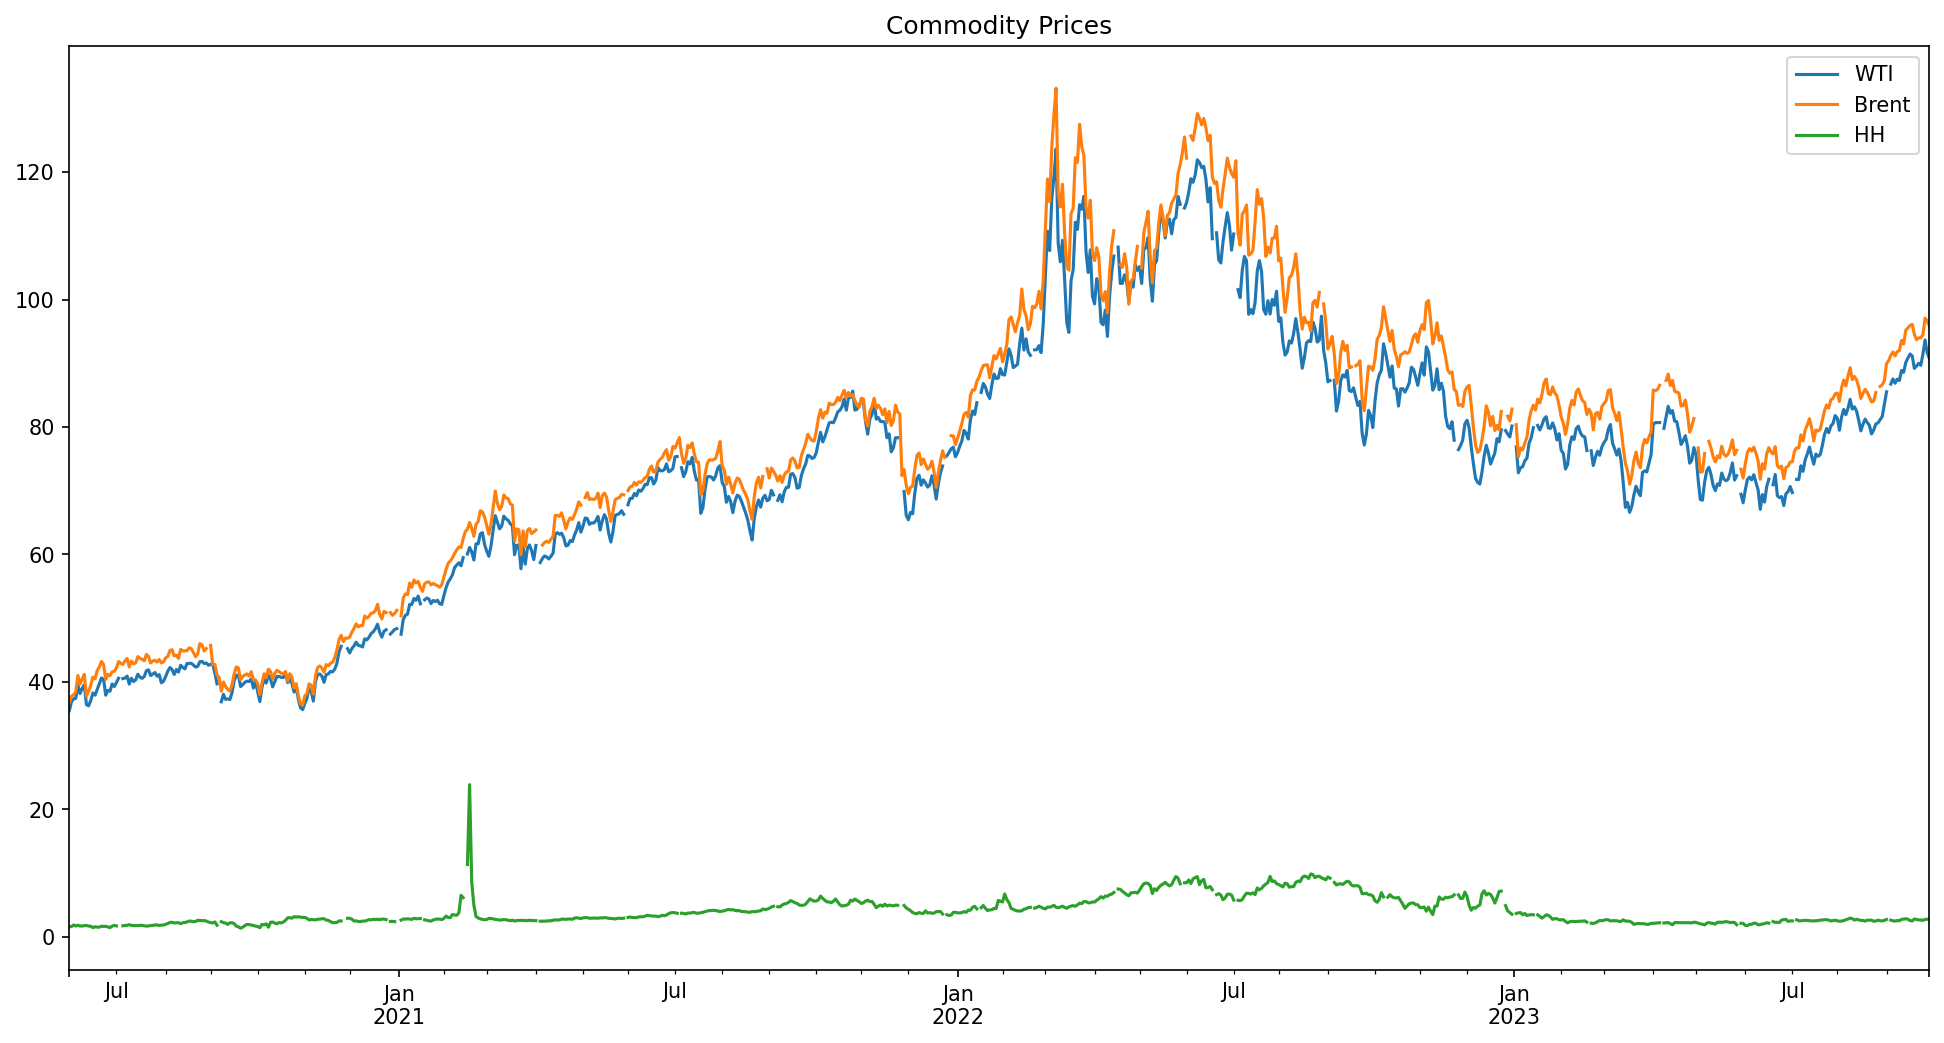

In [4]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [5]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

,DCOILWTICO,DCOILBRENTEU,DHHNGSP,Ret_DCOILWTICO,Ret_DCOILBRENTEU,Ret_DHHNGSP
2020-06-02,36.88,37.72,1.58,0.038418,0.026324,-0.006309
2020-06-03,37.33,37.98,1.84,0.012128,0.006869,0.152341
2020-06-04,37.42,38.41,1.68,0.002408,0.011258,-0.090972
2020-06-05,39.49,41.00,1.80,0.053842,0.065254,0.068993
2020-06-08,38.17,39.66,1.68,-0.033998,-0.033229,-0.068993


# WTI

In [6]:
class data_extraction:
    def __init__(self, data, asset):
        self.data = data
        self.asset = asset
        self.series = self.extract_series()

    def extract_series(self):
        return self.data[self.asset]

In [7]:
class analysis(data_extraction):
    def __init__(self, data, asset):
        data_extraction.__init__(self, data, asset)
        self.x = self.norm_dist()
    
    def acf_log_ret(self):
        plot_acf(self.series, lags=30, title='ACF Log Returns ' + self.asset)
        plt.show()
        
    def acf_sq_log_ret(self):
        plot_acf(self.series**2, lags=30, title='ACF Squared Log Returns ' + self.asset)
        plt.show()
        
    def describe(self):
        return describe(self.series)

    def norm_dist(self):
        mu, sigma = np.mean(self.series), np.std(self.series)
        x = np.random.normal(mu, sigma, 1000)
        x = pd.Series(x, name='Normal Distribution')
        return x
    
    def asset_hist_v_norm(self):
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax2.grid(False)
        ax1.hist(self.series, bins=30)
        g1 = sns.kdeplot(self.x, ax=ax2, color='r')
        g1.set(ylabel=None)
        g1.set(yticklabels=[])
        plt.title('Histogram vs Normal Distribution ' + self.asset);
    
    def asset_dist_v_norm(self):
        sns.set_style('whitegrid')
        series_norm = pd.concat([self.series, self.x], axis=1)
        sns.kdeplot(data=series_norm, bw_method=0.5)
        plt.title('Distribution vs Normal Distribution ' + self.asset);
    
    def arch_test(self):
        return het_arch(self.series)
    
    def arch_test_lag5(self):
        return het_arch(self.series, nlags=5)

In [8]:
analysis_wti = analysis(returns, 'Ret_DCOILWTICO')

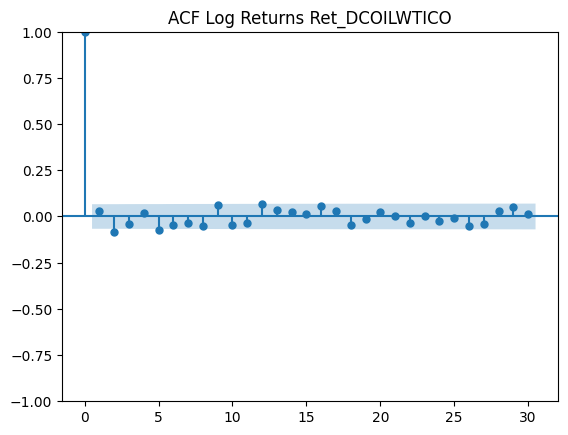

In [9]:
analysis_wti.acf_log_ret()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

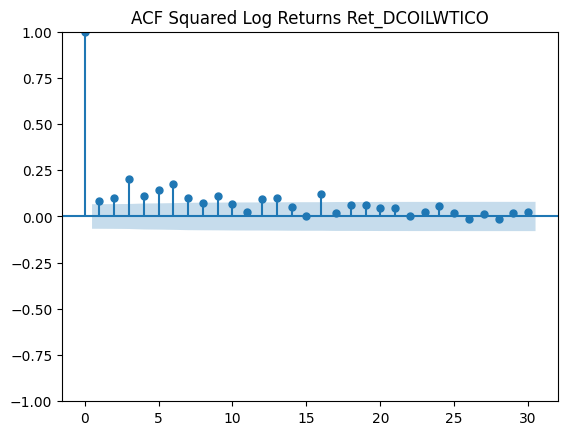

In [10]:
analysis_wti.acf_sq_log_ret()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [11]:
analysis_wti.describe()

,Ret_DCOILWTICO
nobs,8.690000e+02
missing,0.000000e+00
mean,1.080642e-03
std_err,8.235387e-04
upper_ci,2.694748e-03
lower_ci,-5.334643e-04
std,2.427694e-02
iqr,2.791480e-02
iqr_normal,2.069327e-02
mad,1.793358e-02


Negative skewness

High kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

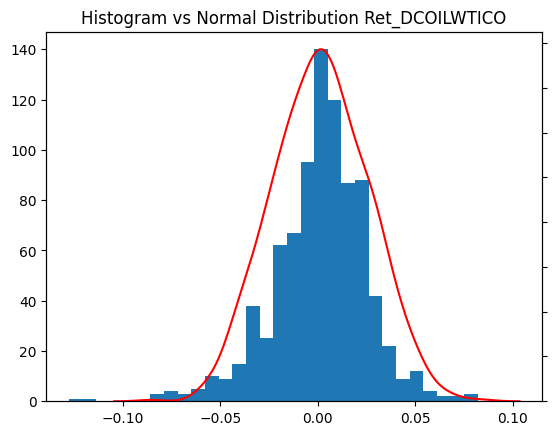

In [12]:
analysis_wti.asset_hist_v_norm()

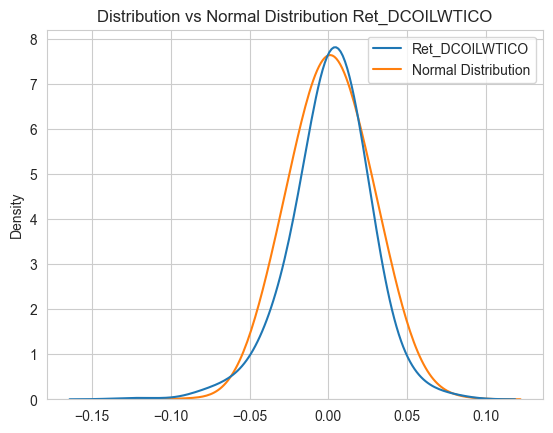

In [13]:
analysis_wti.asset_dist_v_norm()

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [14]:
analysis_wti.arch_test()

(74.01086220849128,
 7.409383379921156e-12,
 7.995169376403505,
 2.158539007848078e-12)

In [15]:
analysis_wti.arch_test_lag5()

(58.30251863526131,
 2.7243829457468232e-11,
 12.417454974371093,
 1.1881259650242177e-11)

H0 no arch effects rejected (p-value close to zero)

## Model Run

In [16]:
class garch_base(data_extraction):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags=0, o=0):
        data_extraction.__init__(self, data, asset)
        self.approach = approach
        self.proportion = proportion
        self.p = p
        self.o = o
        self.q = q
        self.mean = mean
        self.lags = lags
        self.train = self.series.iloc[:int(self.proportion*len(self.series))]
        self.test = self.series.iloc[int(self.proportion*len(self.series)):]
        self.last_train_date = datetime.strftime(self.train.index[-1], '%Y-%m-%d')
        self.res_garch = self.fit()
    
    def specs(self):
        return 'ar' + str(self.lags) + 'garch' + str(self.p) + str(self.q)
    
    def fit(self):
        if self.approach == 'fixed':
            garch = arch.arch_model(self.train, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit()
        elif self.approach == 'roll1d':
            garch = arch.arch_model(self.series, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit(last_obs=self.last_train_date)
            
        return res_garch
    
    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        plt.show()
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()

class garch(garch_base):
    def __init__(self, approach, p, q, mean, data, asset, lags=0, o=0):
        garch_base.__init__(self, approach, p, q, mean, data, asset, lags, o)
        self.forecast = self.forecast()
        self.exclusion_dates = self.get_exclusion_dates()
        self.forecast_mean_values = self.forecast_mean_values()
        self.forecast_std_values = self.forecast_std_values()
        self.forecast_vs_test = self.forecast_vs_test()

    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
#     def forecast_out(self):
#         return self.forecast
    
    def get_exclusion_dates(self):
        return [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= self.last_train_date]
    
    def forecast_mean_values(self):
        if self.approach == 'fixed':
            forecast_mean_values = self.forecast.mean.iloc[0]
        elif self.approach == 'roll1d':
            forecast_mean_values = self.forecast.mean.drop(self.exclusion_dates)
            forecast_mean_values = forecast_mean_values.iloc[:,0]
        
        return forecast_mean_values
    
    def forecast_mean(self):
#         forecast_mean = self.forecast.mean
#         forecast_mean.iloc[0].plot()
        self.forecast_mean_values.plot()

    def forecast_std_values(self):
        forecast_vol_raw = self.forecast.variance**0.5
        
        if self.approach == 'fixed':
            forecast_std_values = forecast_vol_raw.iloc[0]
        elif self.approach == 'roll1d':
            forecast_std_values = forecast_vol_raw.drop(self.exclusion_dates)
            forecast_std_values = forecast_std_values.iloc[:,0]
        
        return forecast_std_values
#         std3 = std2.transpose()
#         for i, col in enumerate(std3.columns):
#             std3[col] = std3[col].shift(i)
#         std3
#         std3.plot()
    
    def forecast_std(self):
#         forecast_stdev = self.forecast.variance**0.5
#         forecast_stdev.iloc[0].plot()
        self.forecast_std_values.plot()
    
    def forecast_vs_test(self):
#         if self.approach == 'fixed':
#             forecast_mean_values = self.forecast.mean.iloc[0].values
#         elif self.approach == 'roll1d':
#             exclusion_dates = [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= last_train_date]
#             forecast_mean_values = self.forecast.mean.drop(exclusion_dates)
#             forecast_mean_values = forecast_mean_values.iloc[:,0].values

        forecast_mean_values = self.forecast_mean_values.values
        
        forecast_mean = pd.Series(forecast_mean_values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

#         forecast_vol_raw = self.forecast.variance**0.5
#         if self.approach == 'fixed':
#             forecast_std_values = forecast_vol_raw.iloc[0].values
#         elif self.approach == 'roll1d':
#             forecast_std_values = forecast_vol_raw.drop(exclusion_dates)
#             forecast_std_values = forecast_std_values.iloc[:,0].values
        
        forecast_std_values = self.forecast_std_values.values
        
        forecast_vs_test_condvol = pd.Series(forecast_std_values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()

In [17]:
garch11_fixed = garch('fixed', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


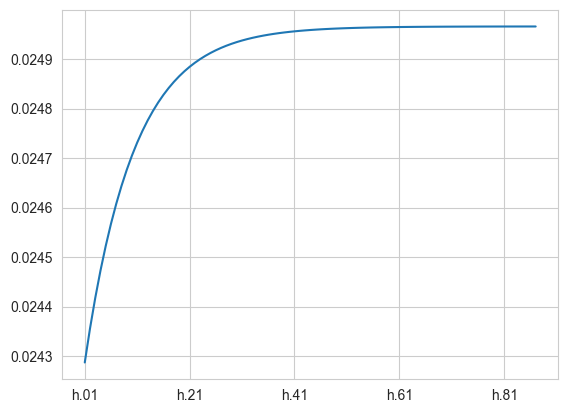

In [18]:
garch11_fixed.forecast_std()

In [19]:
garch11_base = garch_base('roll1d', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1807.5254480262377
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.5254484345394
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
garch11 = garch('roll1d', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1807.5254480262377
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.5254484345394
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1807.53
Distribution:                  Normal   AIC:                          -3609.05
Method:            Maximum Likelihood   BIC:                          -3595.07
                                        No. Observations:                  781
Date:                Sun, Apr 28 2024   Df Residuals:                      781
Time:                        19:46:33   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2361e-05  1.269e-05      4.916  8.839e-07 [3.750e-05,8.722e-05]
alpha[1]       0.1000  2.643e-02      3.783  1.548e-04   [4.819e-02,  0.152]
beta[1]        0.8000  2.716e-02     29.454 1.134e-190     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

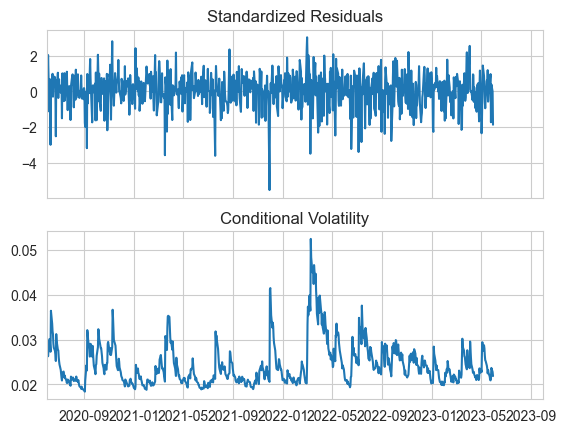

In [22]:
garch11.plot()

In [23]:
garch11.autocorr()

,lb_stat,lb_pvalue
10,NaN,NaN
15,NaN,NaN
20,NaN,NaN


In [24]:
garch11.info_crit()

,AIC,BIC
0,-3609.050897,-3595.069171


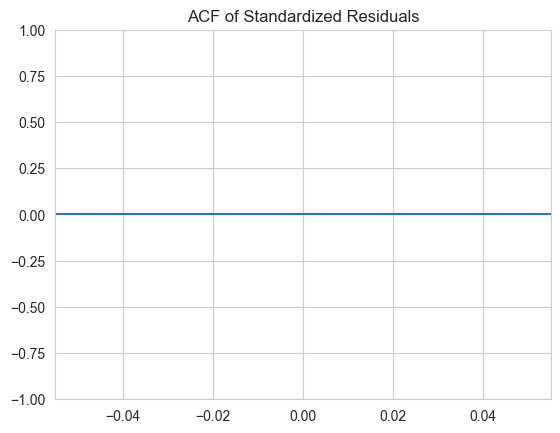

In [25]:
garch11.acf_stan()

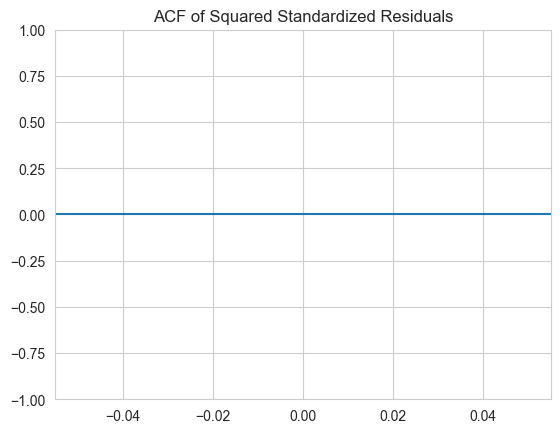

In [26]:
garch11.acf_sq_stan()

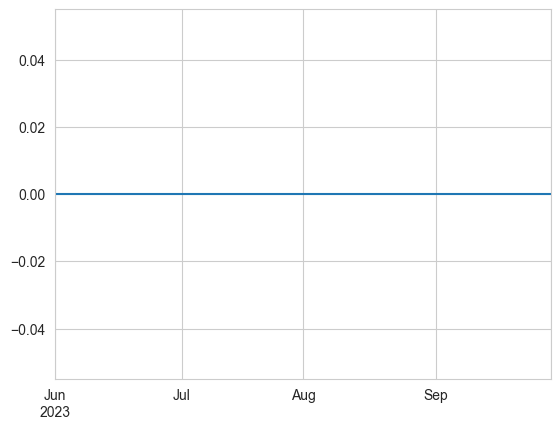

In [27]:
garch11.forecast_mean()

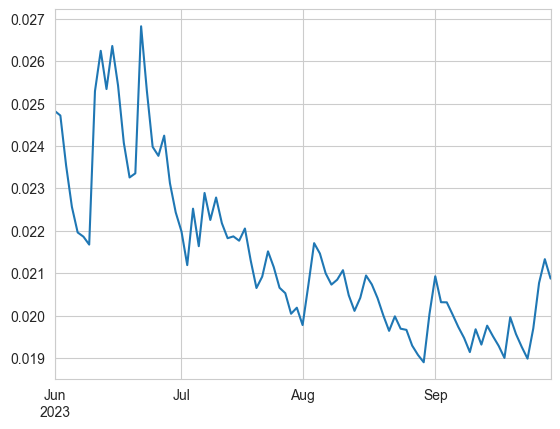

In [28]:
garch11.forecast_std()

In [29]:
garch11.forecast_vs_test

,Ret_Train,Ret_Test,Ret_Forecast,Ret_Test_Broad,Vol_Train,Vol_Test_Broad,Vol_Test,Vol_Forecast
2020-06-02,0.038418,NaN,NaN,0.038418,NaN,NaN,NaN,NaN
2020-06-03,0.012128,NaN,NaN,0.012128,NaN,NaN,NaN,NaN
2020-06-04,0.002408,NaN,NaN,0.002408,NaN,NaN,NaN,NaN
2020-06-05,0.053842,NaN,NaN,0.053842,NaN,NaN,NaN,NaN
2020-06-08,-0.033998,NaN,NaN,-0.033998,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-09-25,NaN,-0.003562,0.0,-0.003562,NaN,0.012104,0.012104,0.018984
2023-09-26,NaN,0.019326,0.0,0.019326,NaN,0.011994,0.011994,0.019698
2023-09-27,NaN,0.024204,0.0,0.024204,NaN,0.011721,0.011721,0.020769
2023-09-28,NaN,-0.021801,0.0,-0.021801,NaN,0.011317,0.011317,0.021330


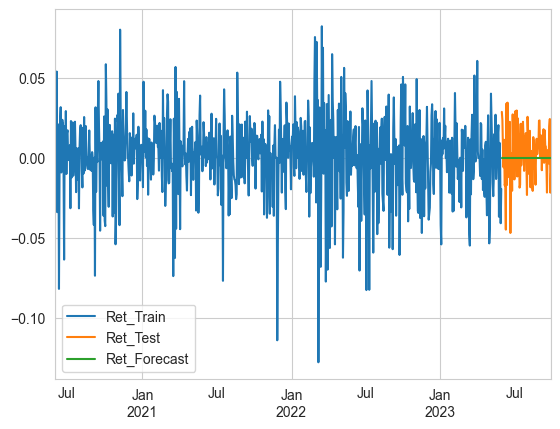

In [30]:
garch11.forecast_vs_test_mean_plot()

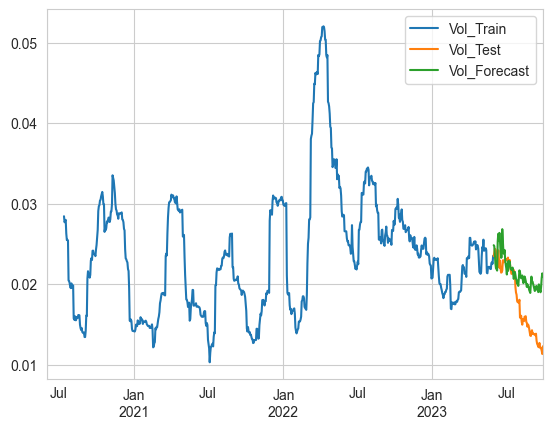

In [31]:
garch11.forecast_vs_test_vol_plot()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggests the mean equation can be modified - AR(2), AR(12) to be added

Prediction is run for the chosen number of days from the last available observation by default. The mean equation continues to be 0 as per the zero mean equation definition at the model setup stage. The variance equation evolves according to GARCH(1,1).

In [32]:
garch12 = garch('roll1d', 0.9, 1, 2, 'Zero', returns, 'Ret_DCOILWTICO')
garch21 = garch('roll1d', 0.9, 2, 1, 'Zero', returns, 'Ret_DCOILWTICO')
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar1garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar1garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar2garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar2garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar2garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar12garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 12)
ar12garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 12)
ar12garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 12)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1806.938370183986
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9383713477746
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1808.1019519935076
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1808.1019527617877
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 2.2707749501226016e+17
Iteration:      2,   Func. Count:     21,   Neg. LLF: 20791602.269243825
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2347209.369241963
Iteration:      4,   Func. Count:     45,   Neg. LLF: 24254116.468416415
Iteration:      5,   Func. Count:     58,   Neg. LLF: 11307516.081901385
Iteration:      6,   Func. Count:     72,   Neg. LLF: 230975670428160.8
Iteration:      7,   Func. Count:     84,   Neg. LLF: -1807.808767996385
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.808768677342
            Iterations: 11
            Function evaluations: 84
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      8,   Neg. LLF: 72191097.90188509
Iteration:      2,   Func. Count:     21,   Neg. LLF: 242941755.04150206
Iteration:      3,   Func. Count:     34,   Neg. LLF: 27507513.822403535
Iteration:      4,   Func. Count:     47,   Neg. LLF: 623044

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 33897866.1427008
Iteration:      2,   Func. Count:     23,   Neg. LLF: 328960.7118080087
Iteration:      3,   Func. Count:     36,   Neg. LLF: 8483682.925058309
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1071678.7692924154
Iteration:      5,   Func. Count:     62,   Neg. LLF: -1806.645871890892
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.6458730224158
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: 3.879082997888776e+17
Iteration:      2,   Func. Count:     23,   Neg. LLF: 355832.9952825104
Iteration:      3,   Func. Count:     36,   Neg. LLF: 202057871027.9335
Iteration:      4,   Func. Count:     48,   Neg. LLF: 17372980.762130223
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2214979684037491.0
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1808.3326

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 752877719.6938083
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1161521.0275931861
Iteration:      3,   Func. Count:     61,   Neg. LLF: 40817701.46639144
Iteration:      4,   Func. Count:     84,   Neg. LLF: 11157029.088757977
Iteration:      5,   Func. Count:    107,   Neg. LLF: 44915193.236777574
Iteration:      6,   Func. Count:    130,   Neg. LLF: 2189.5022162452797
Iteration:      7,   Func. Count:    151,   Neg. LLF: 818838.7322556305
Iteration:      8,   Func. Count:    173,   Neg. LLF: -1796.3140051863795
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1796.3140053268626
            Iterations: 12
            Function evaluations: 173
            Gradient evaluations: 8


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 75870898.4199009
Iteration:      2,   Func. Count:     43,   Neg. LLF: 6316.817708310714
Iteration:      3,   Func. Count:     64,   Neg. LLF: 173001313653113.8
Iteration:      4,   Func. Count:     88,   Neg. LLF: 355090.9522149594
Iteration:      5,   Func. Count:    112,   Neg. LLF: 40058718503613.53
Iteration:      6,   Func. Count:    136,   Neg. LLF: 23608.11865530306
Iteration:      7,   Func. Count:    158,   Neg. LLF: 7618706.9519608915
Iteration:      8,   Func. Count:    182,   Neg. LLF: 3474708.0214550532
Iteration:      9,   Func. Count:    205,   Neg. LLF: -1794.6214447148807
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1794.6214468309004
            Iterations: 13
            Function evaluations: 205
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     19,   Neg. LLF: 264717644.87364516
Iteration:      2,   Func. Count:     43,   Neg. LLF: 13384.56017

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     64,   Neg. LLF: 3.3890814737122554e+17
Iteration:      4,   Func. Count:     88,   Neg. LLF: 4256148.253285081
Iteration:      5,   Func. Count:    110,   Neg. LLF: 5608865.718107266
Iteration:      6,   Func. Count:    134,   Neg. LLF: 1859768.6262518922
Iteration:      7,   Func. Count:    158,   Neg. LLF: -1796.810498885614
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1796.8104997570622
            Iterations: 11
            Function evaluations: 158
            Gradient evaluations: 7


In [33]:
runs = [ar1garch11, ar1garch12, ar1garch21, ar2garch11, ar2garch12, ar2garch21, ar12garch11, ar12garch12, ar12garch21]

for i, ic in enumerate(runs):
    ic_append = ic.info_crit()
    ic_append['Model'] = ic.specs()
    
    if i == 0:
        ics = ic_append
    else:
        ics = pd.concat([ics, ic_append])

cols = ics.columns.tolist()
cols = cols[-1:] + cols[:-1]
ics = ics[cols]
ics

,Model,AIC,BIC
0,ar1garch11,-3603.945858,-3580.649388
0,ar1garch12,-3601.070253,-3573.114490
0,ar1garch21,-3603.617537,-3575.661774
0,ar2garch11,-3602.443080,-3574.495013
0,ar2garch12,-3599.291746,-3566.685669
0,ar2garch21,-3602.665247,-3570.059170
0,ar12garch11,-3560.628011,-3486.306555
0,ar12garch12,-3555.242894,-3476.276347
0,ar12garch21,-3559.621000,-3480.654453


In [34]:
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [35]:
ar1garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                1806.97
Distribution:                  Normal   AIC:                          -3603.95
Method:            Maximum Likelihood   BIC:                          -3580.65
                                        No. Observations:                  780
Date:                Sun, Apr 28 2024   Df Residuals:                      778
Time:                        19:46:38   Df Model:                            2
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.0865e-03  7.986e-04      1.361      0.174 [-4.787e-04,2.652e-03]
Ret_...ICO[1]     0.0254  3.871e-02      0.657      0.511   [-5.045e-02,  0.101]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1981e-05  1.337e-05      4.637  3.530e-06 [3.578e-05,8.818e-05]
alpha[1]       0.1020  2.728e-02      3.740  1.843e-04   [4.855e-02,  0.155]
beta[1]        0.7982  2.814e-02     28.367 5.176e-177     [  0.743,  0.853]
============================================================================

Covariance estimator: robust
"""

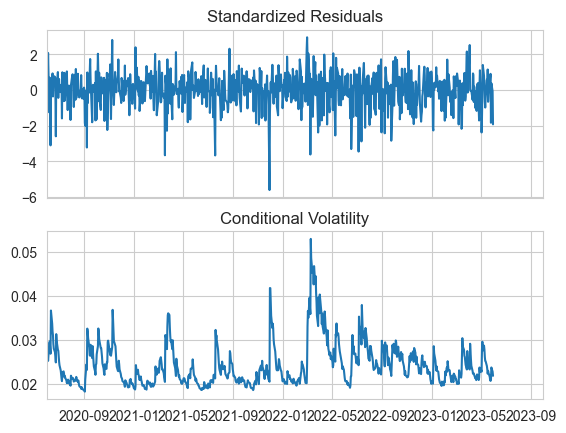

In [36]:
ar1garch11.plot()

In [37]:
ar1garch11.autocorr()

,lb_stat,lb_pvalue
10,NaN,NaN
15,NaN,NaN
20,NaN,NaN


In [38]:
ar1garch11.info_crit()

,AIC,BIC
0,-3603.945858,-3580.649388


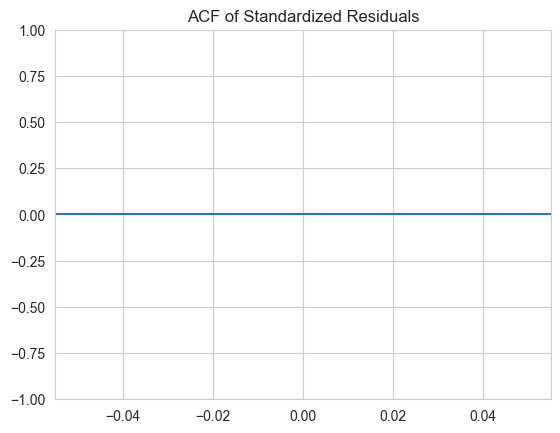

In [39]:
ar1garch11.acf_stan()

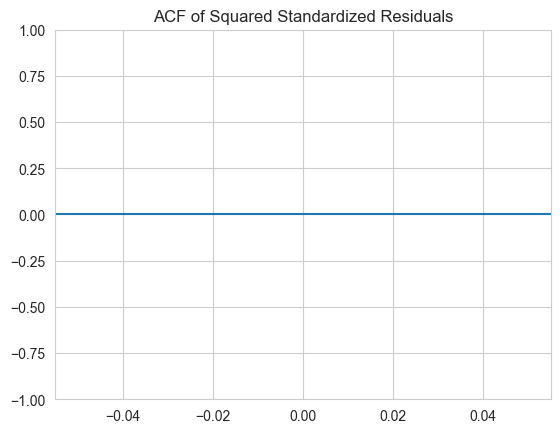

In [40]:
ar1garch11.acf_sq_stan()

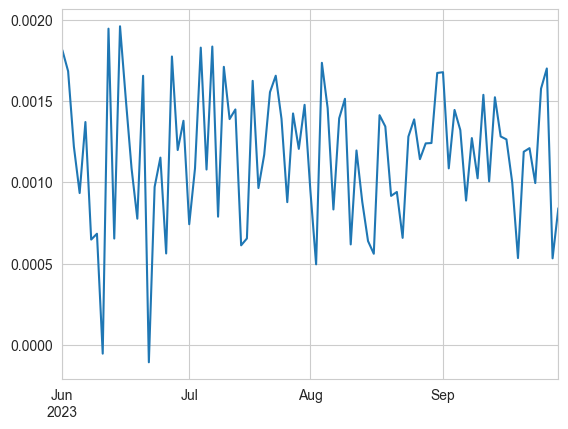

In [41]:
ar1garch11.forecast_mean()

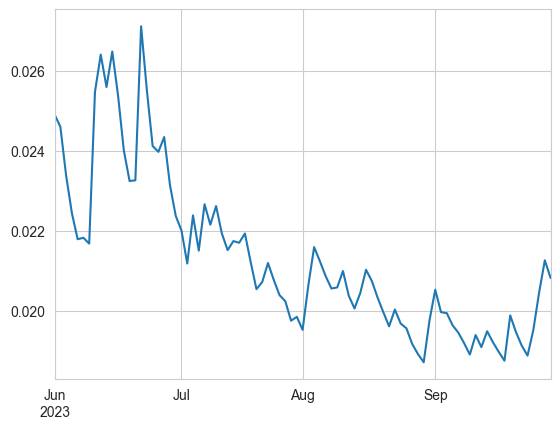

In [42]:
ar1garch11.forecast_std()

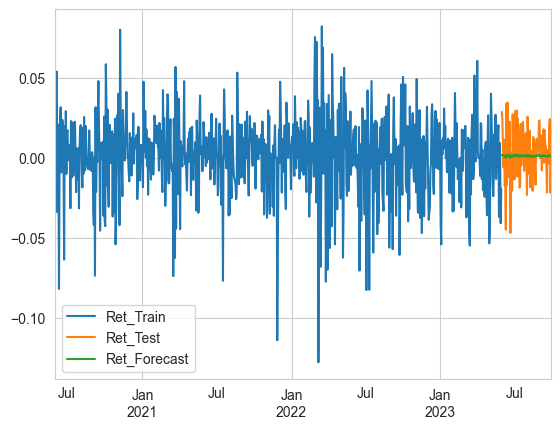

In [43]:
ar1garch11.forecast_vs_test_mean_plot()

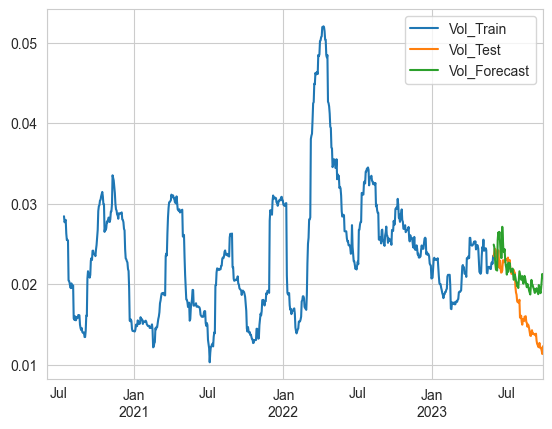

In [44]:
ar1garch11.forecast_vs_test_vol_plot()

Add GJR-GARCH, TARCH and trading strategy logic

In [45]:
class strategy(garch):
    def __init__(self, approach, p, q, mean, data, asset, lags, o):
        garch.__init__(self, approach, p, q, mean, data, asset, lags, o)
        self.trade = self.build()
    
    def build(self):
        trade = self.forecast_vs_test
        
        last_train = trade.iloc[lambda x: x.index == self.last_train_date]
        last_vol_train = last_train['Vol_Train'][0]

        trade['direction'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Ret_Forecast'] > 0, 1, -1))
        trade['amplifier'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Vol_Forecast'] > last_vol_train, 2, 1))
        trade['position'] = trade['direction'] * trade['amplifier']
        trade['pnl'] = trade['Ret_Test'] * trade['position']
        trade['pnl_cum'] = trade['pnl'].cumsum()
        
        trade = trade.iloc[lambda x: x.index >= self.last_train_date]
        
        return trade
    
    def pos(self):
        window = self.trade
        
        plt.figure(figsize=(16, 8), dpi=150) 

        window['direction'].plot(label='Direction')
        window['amplifier'].plot(label='Amplifier')
        window['position'].plot(label='Position')

        plt.title('Trading Positions')
        plt.legend()
        
    def pnl(self):
        window = self.trade
        
        plt.figure(figsize=(16, 8), dpi=150) 

        window['pnl'].plot(label='P&L')
        window['pnl_cum'].plot(label='Cumulative P&L')

        plt.title('Trading P&L')
        plt.legend()   

In [46]:
ar1garch11_strat = strategy('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [47]:
ar1garch11_strat.build()

,Ret_Train,Ret_Test,Ret_Forecast,Ret_Test_Broad,Vol_Train,Vol_Test_Broad,Vol_Test,Vol_Forecast,direction,amplifier,position,pnl,pnl_cum
2023-05-31,-0.019483,NaN,NaN,-0.019483,0.023509,0.023509,NaN,NaN,0,0,0,NaN,NaN
2023-06-01,NaN,0.028656,0.001815,0.028656,0.023478,0.023478,0.023478,0.024905,1,2,2,0.057312,0.057312
2023-06-02,NaN,0.023547,0.001685,0.023547,NaN,0.023961,0.023961,0.024602,1,2,2,0.047094,0.104406
2023-06-05,NaN,0.005281,0.001221,0.005281,NaN,0.024383,0.024383,0.023376,1,1,1,0.005281,0.109688
2023-06-06,NaN,-0.005978,0.000935,-0.005978,NaN,0.024314,0.024314,0.022437,1,1,1,-0.005978,0.103709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,NaN,-0.003562,0.000996,-0.003562,NaN,0.012104,0.012104,0.018872,1,1,1,-0.003562,0.675713
2023-09-26,NaN,0.019326,0.001578,0.019326,NaN,0.011994,0.011994,0.019508,1,1,1,0.019326,0.695039
2023-09-27,NaN,0.024204,0.001702,0.024204,NaN,0.011721,0.011721,0.020444,1,1,1,0.024204,0.719243
2023-09-28,NaN,-0.021801,0.000532,-0.021801,NaN,0.011317,0.011317,0.021259,1,1,1,-0.021801,0.697442


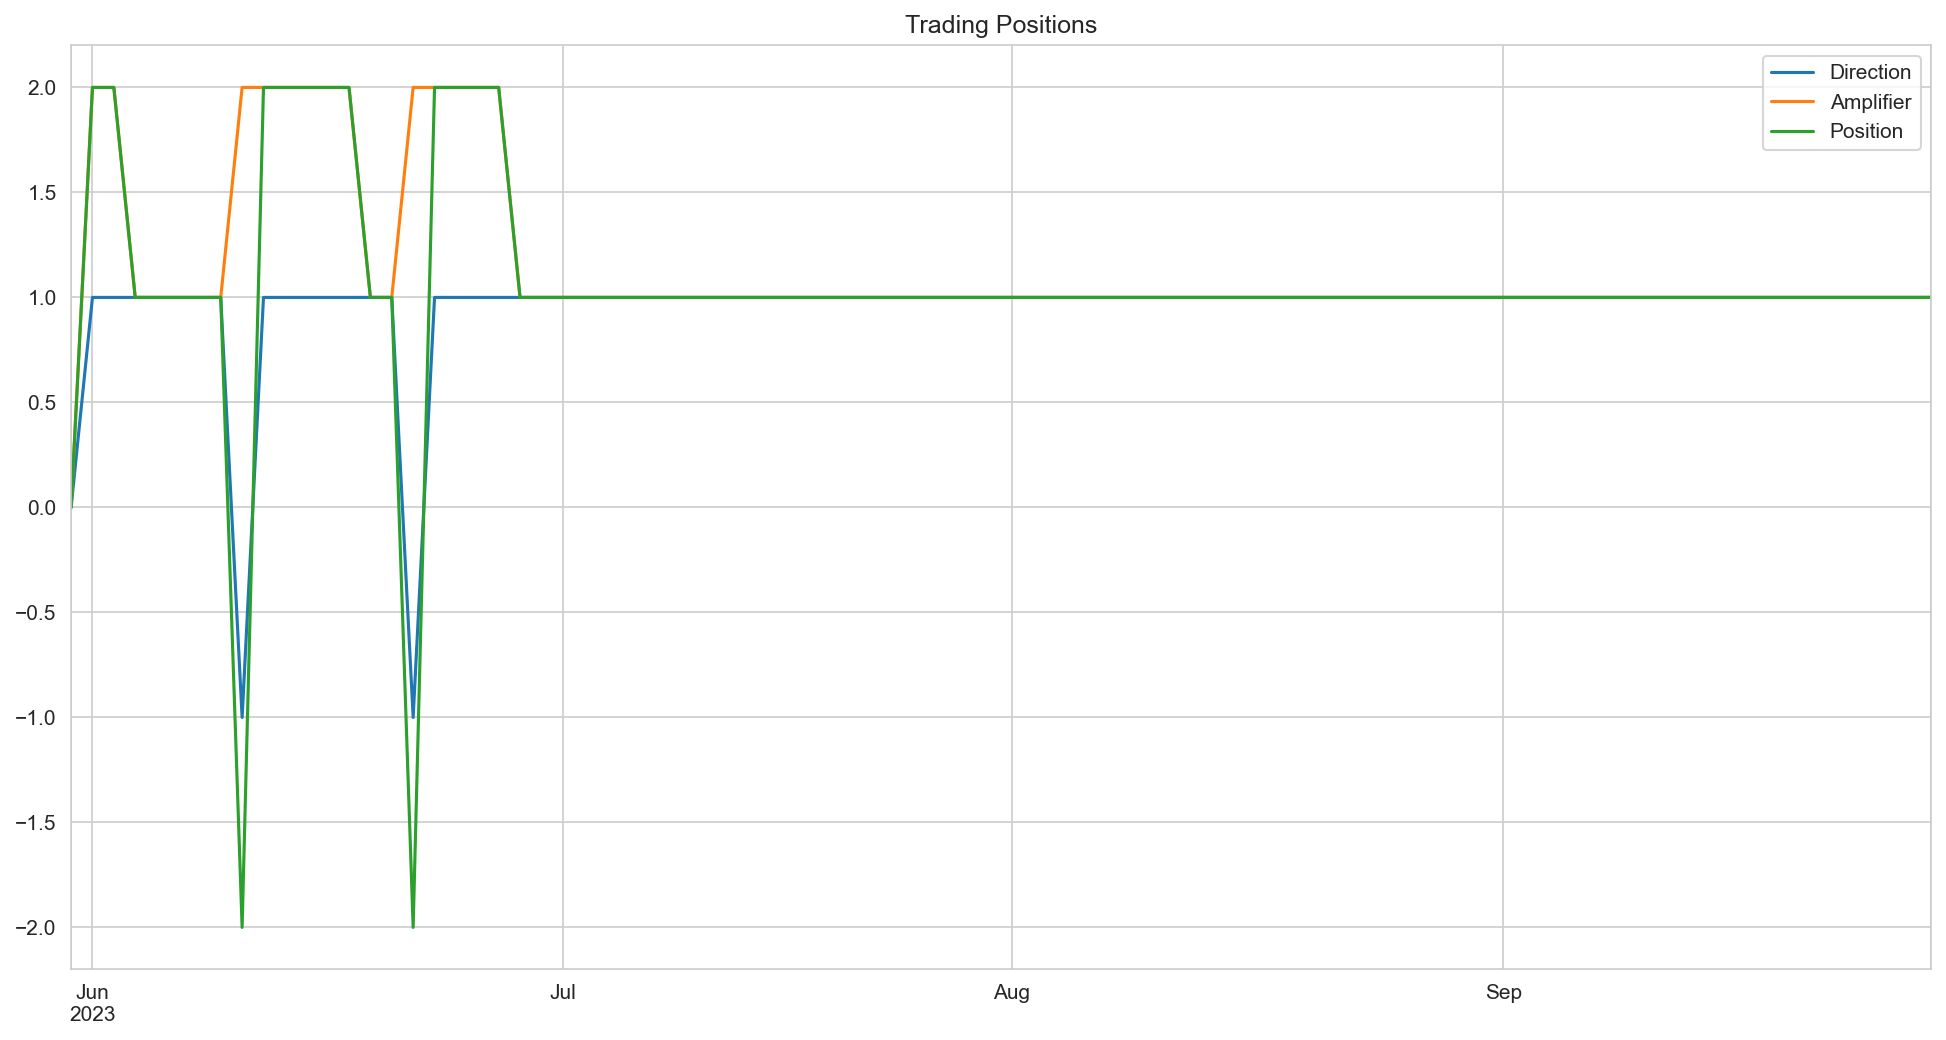

In [48]:
ar1garch11_strat.pos()

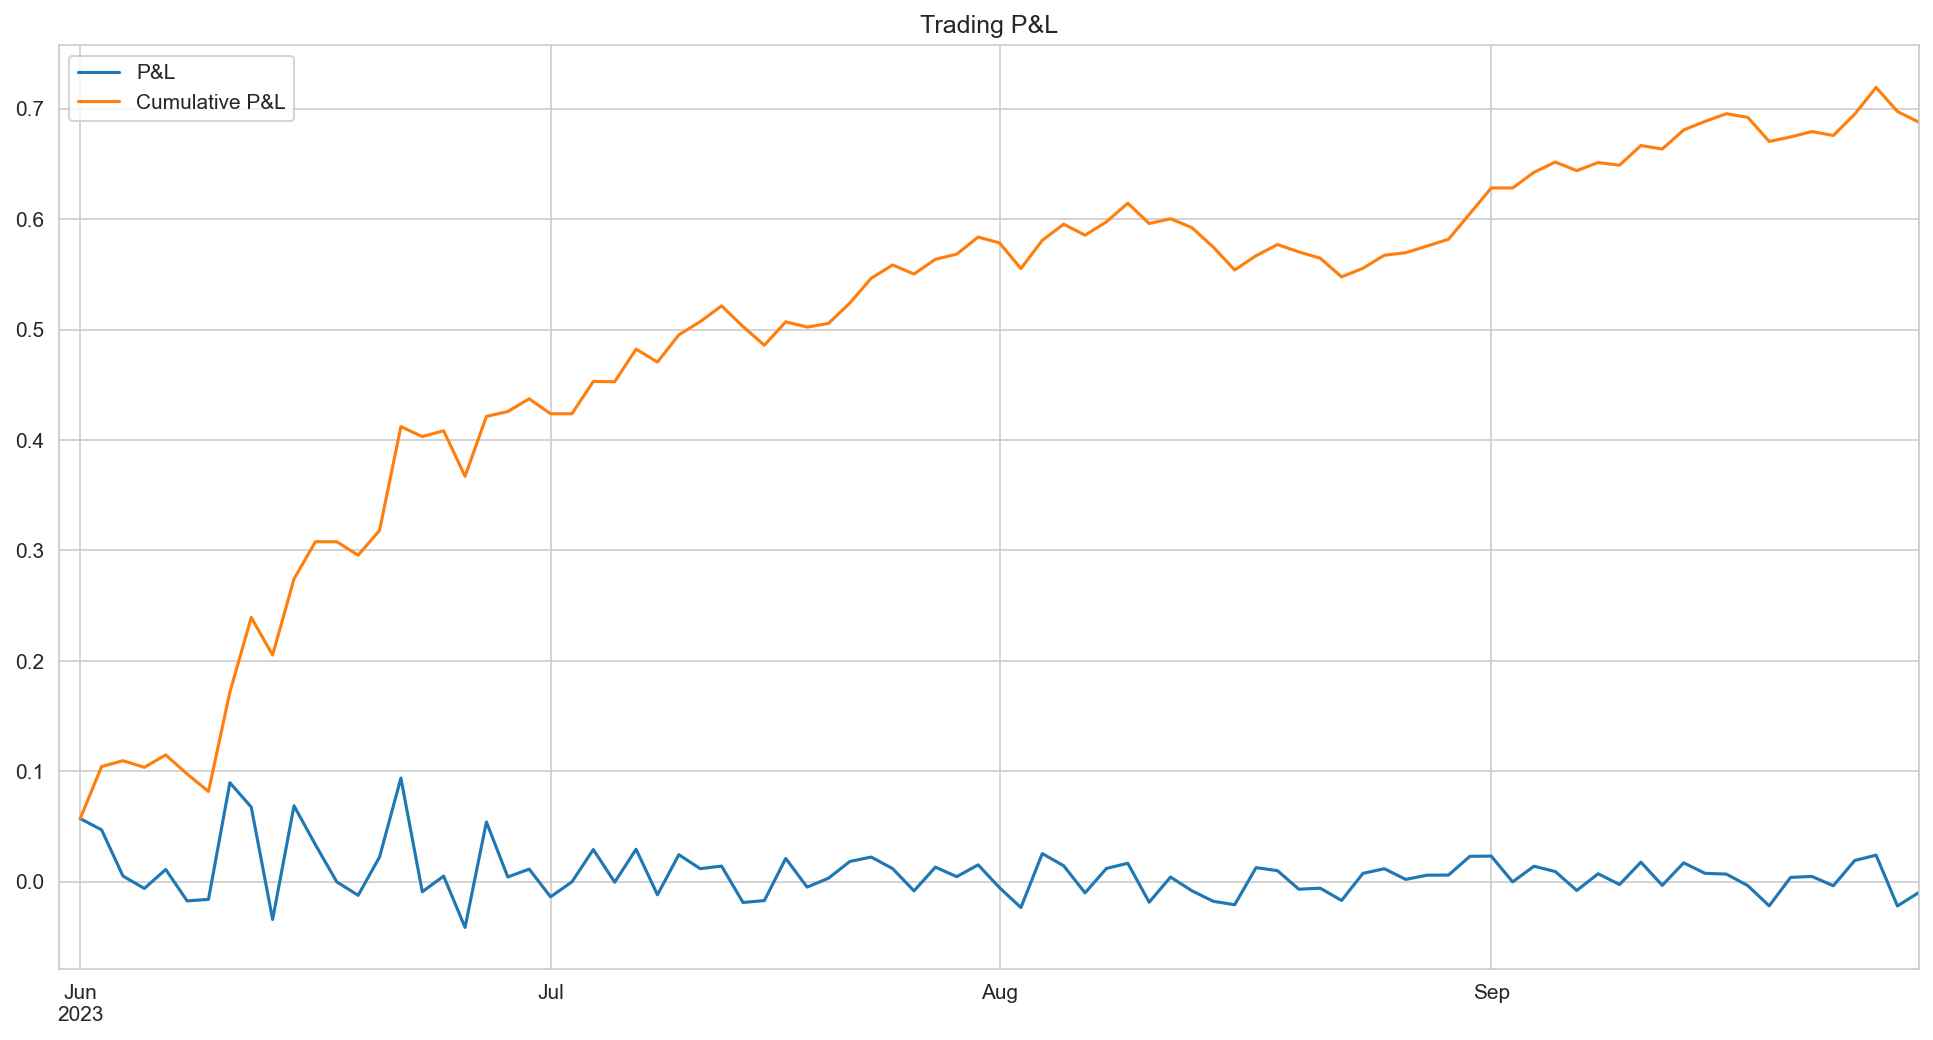

In [49]:
ar1garch11_strat.pnl()